In [39]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import SubsetRandomSampler
import numpy as np
import copy
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import os
import torch.utils.data as tdata
from PIL import Image
import random
import math
from matplotlib import animation, rc
from IPython.display import HTML

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [41]:
epoch_time = -1
epoch_space = 5
def is_epoch():
  global epoch_time
  curr_t = time.time()
  if (curr_t - epoch_time) > epoch_space:
    epoch_time = curr_t
    return True
  return False

image_time = -1
image_space = 5
def is_image():
  global image_time
  curr_t = time.time()
  if (curr_t - image_time) > image_space:
    image_time = curr_t
    return True
  return False

In [42]:
def imshow_list(l, scale=1.0):
  if scale == 1.0:
    fig = plt.figure()
  else:
    fig = plt.figure(figsize=(scale*7,scale*4))
  for i, im in enumerate(l):
    try:
      im = im.cpu().detach().squeeze()
    except:
      pass
    im = im.squeeze()
    plt.subplot(1,len(l),i+1)
    #plt.tight_layout()
    plt.imshow(im, cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])

  plt.show()

#### 
## Load and process dataset into loaders:

In [43]:
arrs = None
dat = None

arrs = np.load('ball_collisions.npz')
dat = arrs['array1']
arrs = None
dat = torch.from_numpy(dat)
dat.size()

torch.Size([100000, 4, 32, 32])

In [44]:
class GeneticBalls(tdata.Dataset):
  def __init__(self, dat, train):
    self.dat = dat # I think need to convert to cuda here
    self.train = train

  def __getitem__(self, index):
    if self.train:
      seq = self.dat[index].to(torch.float)
    else:
      seq = self.dat[90000+index].to(torch.float)
      
    return seq

  def __len__(self):
    if self.train:
      return 90000
    else:
      return 10000

In [45]:
def make_loaders(dat):
  train_set = GeneticBalls(dat, True)
  test_set = GeneticBalls(dat, False)

  batch_size_train = 128
  batch_size_test = 1000

  train_loader = torch.utils.data.DataLoader(
                   dataset=train_set,
                   batch_size=batch_size_train,
                   shuffle=True)

  test_loader = torch.utils.data.DataLoader(
                  dataset=test_set,
                  batch_size=batch_size_test,
                  shuffle=True)

  print('==>>> total trainning batches: {}'.format(len(train_loader)))
  print('==>>> total testing batches: {}'.format(len(test_loader)))

  for seq in train_loader:
      print('--- Sample')
      print('Input: ', seq.shape)
      break
      
  return train_loader, test_loader

In [46]:
train_loader, test_loader = make_loaders(dat)

==>>> total trainning batches: 704
==>>> total testing batches: 10
--- Sample
Input:  torch.Size([128, 4, 32, 32])


#### Plot sample animations from the dataset:

   FRAME 1  |  FRAME 2  |  FRAME 3  |  FRAME 4



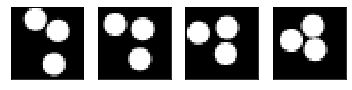

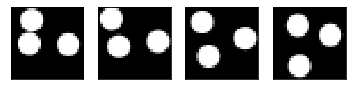

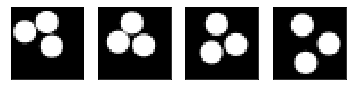

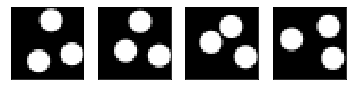

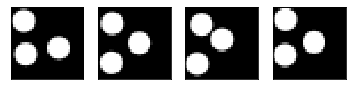

In [103]:
examples = enumerate(test_loader)
batch_idx, data = next(examples)

print('   FRAME 1  |  FRAME 2  |  FRAME 3  |  FRAME 4')
for i in range(5):
  print('')
  imshow_list([data[i][0], data[i][1], data[i][2], data[i][3]])

#### 
## Training an autoencoder on the dataset
#### This will later be used to parametrize the dataset

In [56]:
class P(nn.Module):
  # Predictor
  def __init__(self):
    super(P, self).__init__()
    self.fc1 = nn.Linear(2*16, 128)
    self.fc2 = nn.Linear(128, 128)
    self.fc3 = nn.Linear(128, 16)
    self.leaky_relu = nn.LeakyReLU(0.2)

  def forward(self, x1, x2):
    x = torch.cat((x1, x2), dim=1)
    x = self.leaky_relu(self.fc1(x))
    x = self.leaky_relu(self.fc2(x))
    x = self.fc3(x)
    
    return x

class AE(nn.Module):
  # AutoEncoder
  def __init__(self):
    super(AE, self).__init__()
    self.fc1 = nn.Linear(32*32, 128)
    self.fc2 = nn.Linear(128, 16)
    self.fc3 = nn.Linear(16, 128)
    self.fc4 = nn.Linear(128, 32*32)
    self.leaky_relu = nn.LeakyReLU(0.2)
    self.sigmoid = nn.Sigmoid()
    
  def encode(self, x):
    x = x.view(-1, 32*32)
    x = self.leaky_relu(self.fc1(x))
    x = self.fc2(x)
    
    return x
    
  def decode(self, x):
    x = self.leaky_relu(self.fc3(x))
    x = self.sigmoid(self.fc4(x))
    x = x.view(-1, 1, 32, 32)
    
    return x
    
  def forward(self, x):
    x = self.encode(x)
    x = self.decode(x)
    
    return x
  
  
mse = nn.MSELoss()

#### Load previously trained autoencoder parameters (if exists):

In [57]:
ae = AE().to(device)
ae.load_state_dict(torch.load('autoencoder.pt'))

<All keys matched successfully>

#### Autoencoder training: (do not run next cell if using preloaded parameters from previous cell)

In [ ]:
ae = AE().to(device)
optimizer = optim.Adam(ae.parameters(), lr=0.001)

for epoch in range(1, 300+1):
  for batch_idx, data in enumerate(train_loader):
    I4 = data[:,3:4,:,:].to(device)

    optimizer.zero_grad()
    out = ae(I4)
    loss = mse(out, I4)
    loss.backward()
    optimizer.step()

    if is_epoch():
      print('Epoch {} ({:.0f}%) | loss {}'.format(
        epoch,
        100. * batch_idx / len(train_loader),
        loss.data.item(),
      ))
      if is_image():
        imshow_list([I4[0], out[0]])
        
print('Done!')

#### Autoencoder evaluation samples:

  ORIGINAL   |   AUTOENCODED



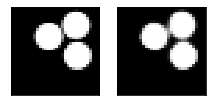

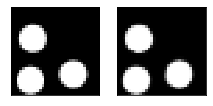

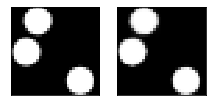

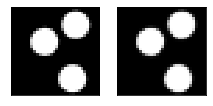

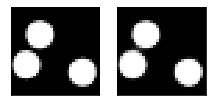

mse 0.001094


In [110]:
ae.eval()

examples = enumerate(test_loader)
batch_idx, data = next(examples)

I4 = data[:,3:4,:,:].to(device)
out = ae(I4)
loss = mse(out, I4)

print('  ORIGINAL   |   AUTOENCODED')
for i in range(5):
  print('')
  imshow_list([I4[i], out[i]], scale=0.5)
    
print('mse {:.6f}'.format(loss))

#### Save autoencoder parameters:

In [ ]:
torch.save(ae.state_dict(), 'autoencoder.pt')

#### 
## Train a simple feedforward predictor
#### This is to show limitations and to compare with the next approach

In [68]:
class Pred(nn.Module):
  # Predictor
  def __init__(self):
    super(Pred, self).__init__()
    self.fc1 = nn.Linear(3*32*32, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 32)
    self.fc4 = nn.Linear(32, 256)
    self.fc5 = nn.Linear(256, 512)
    self.fc6 = nn.Linear(512, 32*32)
    
    self.leaky_relu = nn.LeakyReLU(0.2)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x1, x2, x3):
    x = torch.cat((x1, x2, x3), dim=1)
    x = x.view(-1, 3*32*32)
    x = self.leaky_relu(self.fc1(x))
    x = self.leaky_relu(self.fc2(x))
    x = self.leaky_relu(self.fc3(x))
    x = self.leaky_relu(self.fc4(x))
    x = self.leaky_relu(self.fc5(x))
    x = self.sigmoid(self.fc6(x))
    x = x.view(-1, 1, 32, 32)
    
    return x

#### Load previously trained feedforward predictor parameters (if exists):

In [69]:
pred = Pred().to(device)
pred.load_state_dict(torch.load('bottom_up_predictor.pt'))

<All keys matched successfully>

#### Feedforward predictor training: (do not run next cell if using preloaded parameters from previous cell)

In [ ]:
pred = Pred().to(device)
optimizer = optim.Adam(pred.parameters(), lr=0.001)
mse = nn.MSELoss()

for epoch in range(1, 100+1):
  for batch_idx, data in enumerate(train_loader):
    I1 = data[:,0:1,:,:].to(device)
    I2 = data[:,1:2,:,:].to(device)
    I3 = data[:,2:3,:,:].to(device)
    I4 = data[:,3:4,:,:].to(device)

    optimizer.zero_grad()
    out = pred(I1, I2, I3)
    loss = mse(out, I4)
    loss.backward()
    optimizer.step()

    if is_epoch():
      print('Epoch {} ({:.0f}%) | loss {}'.format(
        epoch,
        100. * batch_idx / len(train_loader),
        loss.data.item(),
      ))
      if is_image():
        imshow_list([I1[0], I2[0], I3[0], I4[0], out[0]], scale=2.0)
        
print('Done!')

#### Feedforward predictor evaluation samples:

FRAME 1 (INPUT) | FRAME 2 (INPUT) | FRAME 3 (INPUT) | FRAME 4 (GROUND-TRUTH) | FRAME 4 (PREDICTION)



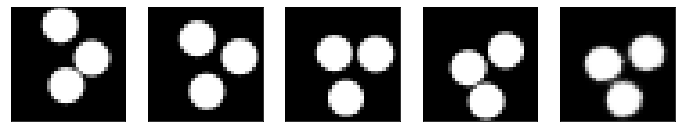

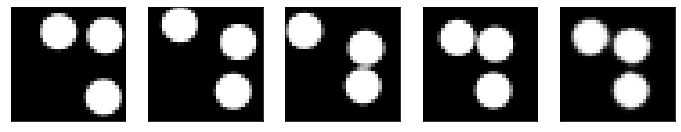

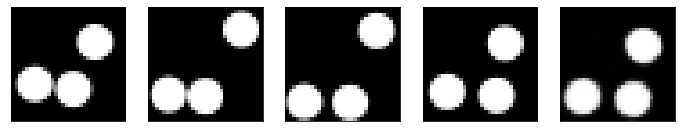

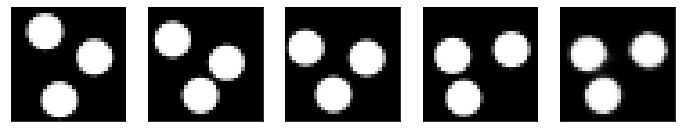

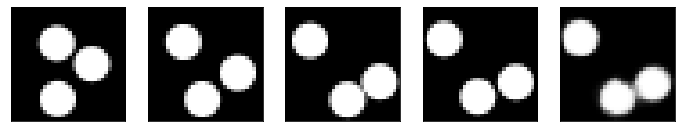

mse 0.026425


In [140]:
pred.eval()

examples = enumerate(test_loader)
batch_idx, data = next(examples)

I1 = data[:,0:1,:,:].to(device)
I2 = data[:,1:2,:,:].to(device)
I3 = data[:,2:3,:,:].to(device)
I4 = data[:,3:4,:,:].to(device)

out = pred(I1, I2, I3)
loss = mse(out, I4)

print('FRAME 1 (INPUT) | FRAME 2 (INPUT) | FRAME 3 (INPUT) | FRAME 4 (GROUND-TRUTH) | FRAME 4 (PREDICTION)')
for i in range(5):
  print('')
  imshow_list([I1[i], I2[i], I3[i], I4[i], out[i]], scale=1.7)

print('mse {:.6f}'.format(loss))

#### Save feedforward predictor parameters:

In [ ]:
torch.save(pred.state_dict(), 'bottom_up_predictor.pt')

####
## Input gradient descent
#### The following function performs (deterministic) gradient descent over the input space of a given function:

In [18]:
def input_gd(x, f, steps=30, lr=300, momentum=1.0, verbose=False, zero_grad_f=None, threshold=None):
  x = Variable(x, requires_grad=True)
  lr = lr*x.shape[0]
  optimizer = optim.SGD([x], lr=lr, momentum=momentum)
  if verbose:
    print('GD iterations:')
    
  min_steps = steps
  if threshold is not None:
    is_thresh = True
    steps = 10000
  for i in range(steps):
    optimizer.zero_grad()
    if zero_grad_f is not None:
      zero_grad_f()
    out = f(x)

    if verbose:
      print('i={} | err={:.6f}'.format(i, out.item()))
      
    if threshold is not None and out.item() < threshold and i > min_steps:
      break
      
    out.backward()
    #x.data = x.data-lr*x.grad.data/torch.norm(x.grad.data)
    optimizer.step()
    
  return x.data

#### Test the above function on the task of reconstructing a frame $I_{2}$, using the previous frame $I_{1}$ as the initial guess $x_{0}$. <br> The function used in the minimization is $MSE(x, I_{2})$.

GD iterations:
i=0 | err=0.115033
i=1 | err=0.089960
i=2 | err=0.061517
i=3 | err=0.039662
i=4 | err=0.025158
i=5 | err=0.015870
i=6 | err=0.010175
i=7 | err=0.006740
i=8 | err=0.004652
i=9 | err=0.003362
i=10 | err=0.002552
i=11 | err=0.002022
i=12 | err=0.001690
i=13 | err=0.001470
i=14 | err=0.001265
i=15 | err=0.001162
i=16 | err=0.001095
i=17 | err=0.001028
i=18 | err=0.000984
i=19 | err=0.000942
i=20 | err=0.000898
i=21 | err=0.000889
i=22 | err=0.000863
i=23 | err=0.000830
i=24 | err=0.000827
i=25 | err=0.000811
i=26 | err=0.000785
i=27 | err=0.000781
i=28 | err=0.000774
i=29 | err=0.000760

I1 (INITIAL GUESS) | I2 (TARGET) | RECONSTRUCTION


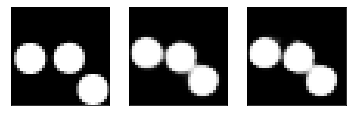

mse 0.000652


In [111]:
ae.eval()

examples = enumerate(test_loader)
batch_idx, data = next(examples)

I1 = data[:,0:1,:,:].to(device)
I2 = data[:,1:2,:,:].to(device)

gt = ae(I2)

x = input_gd(ae.encode(I1).data, (lambda x: mse(ae.decode(x), I2)), steps=30, lr=300, momentum=0.5, verbose=True)
reconst = ae.decode(x)

print('\nI1 (INITIAL GUESS) | I2 (TARGET) | RECONSTRUCTION')
imshow_list([I1[0:1], gt[0:1], reconst[0:1]])

reconst_err = mse(gt, reconst)
print('mse {:.6f}'.format(reconst_err))

####
## Parametrize the dataset
#### The first half of the autoencoder (the encoder) is used to compute and save the compressed representations of the last frame input in each animation in the dataset ($I_{3}$) and the expected output ($I_{4}$).

#### Load previously computed parametrization (if exists):

In [176]:
codes_dat = torch.load('codes_dat.pt')

#### Compute parametrization: (do not run next cell if using preloaded parametrization from previous cell)

In [ ]:
ae.eval()
steps=100
lr=300
momentum=0.5
codes_dat = torch.empty((100000, 2, 16+1), device=device)
for i in range(100):
  print('i = {}/100'.format(i))
  
  I3 = dat[i*1000:(i+1)*1000, 2:3].to(torch.float).to(device)
  I4 = dat[i*1000:(i+1)*1000, 3:4].to(torch.float).to(device)
  
  # the following trick further improves the parametrization achieved from the autoencoder by
  # using the input_gd() function to refine the encoded representations by minimizing the
  # reconstruction error given the ground-truth
  x = input_gd(ae.encode(I3).data, (lambda x: mse(ae.decode(x), I3)), steps=steps, lr=lr, momentum=momentum)
  codes_dat[i*1000:(i+1)*1000, 0, 0:16] = x
  codes_dat[i*1000:(i+1)*1000, 0, 16] = torch.arange(i*1000, (i+1)*1000)
  if i == 0:
    print(mse(ae.decode(x), I3).item())
    
  x = input_gd(ae.encode(I4).data, (lambda x: mse(ae.decode(x), I4)), steps=steps, lr=lr, momentum=momentum)
  codes_dat[i*1000:(i+1)*1000, 1, 0:16] = x
  codes_dat[i*1000:(i+1)*1000, 1, 16] = torch.arange(i*1000, (i+1)*1000)  
  if i == 0:
    print(mse(ae.decode(x), I4).item())
      
print('Done!')

#### Plot sample reconstructions from parametrized representations using the second half of the autoencoder (the decoder). <br> Note improved MSE errors over the initial autoencoder reconstructions.

In [177]:
codes_train_loader, codes_test_loader = make_loaders(codes_dat)

==>>> total trainning batches: 704
==>>> total testing batches: 10
--- Sample
Input:  torch.Size([128, 2, 17])


  I3 DECODED  |  I4 DECODED



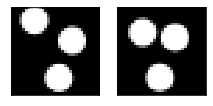

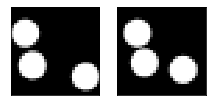

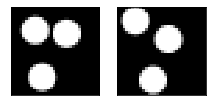

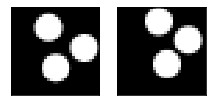

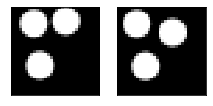

mse 0.000539
mse 0.000534


In [178]:
examples = enumerate(codes_test_loader)
batch_idx, data = next(examples)

print('  I3 DECODED  |  I4 DECODED')
for i in range(5):
  print('')
  imshow_list([dat[int(data[i,0,16].item()), 2], dat[int(data[i,1,16].item()), 3]], scale=0.5)

err = mse(ae.decode(data[:,0,0:16]), dat[data[:,0,16].to(torch.long), 2:3].to(torch.float).to(device)).item()
print('mse {:.6f}'.format(err))
err = mse(ae.decode(data[:,1,0:16]), dat[data[:,1,16].to(torch.long), 3:4].to(torch.float).to(device)).item()
print('mse {:.6f}'.format(err))

#### Save parametrization:

In [ ]:
torch.save(codes_dat, 'codes_dat.pt')

####
## cGAN-style discriminator-based prediction
#### Except there is no generator network. Instead, predictions are generated at each step by minimizing the discriminator value using input_gd() over the $I_{4}$ parameter space.

In [155]:
class D(nn.Module):
  # Predictor
  def __init__(self):
    super(D, self).__init__()
    self.fc1 = nn.Linear(4*32*32, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 32)
    self.fc4 = nn.Linear(32, 1)
    
    self.leaky_relu = nn.LeakyReLU(0.2)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x1, x2, x3, x4, activation=True):
    x = torch.cat((x1, x2, x3, x4), dim=1)
    x = x.view(-1, 4*32*32)
    x = self.leaky_relu(self.fc1(x))
    x = self.leaky_relu(self.fc2(x))
    x = self.leaky_relu(self.fc3(x))
    x = self.fc4(x)
    if activation:
      x = self.sigmoid(x)
    
    return x

In [156]:
def evaluate(net, verbose=False, num_show=1, threshold=None):
  errors = []
  for batch_idx, data in enumerate(codes_test_loader):
    verbose = verbose and batch_idx == 0
    
    I1 = dat[data[:,0,16].to(torch.long),0:1,:,:].to(torch.float).to(device)
    I2 = dat[data[:,0,16].to(torch.long),1:2,:,:].to(torch.float).to(device)
    I3 = dat[data[:,0,16].to(torch.long),2:3,:,:].to(torch.float).to(device)
    I3_x = data[:,0,0:16]
    I4 = ae.decode(data[:,1,0:16])

    f = (lambda x: -d(I1, I2, I3, ae.decode(x), activation=False).mean())
    x = input_gd(
      I3_x, f,
      steps=steps, lr=lr, momentum=momentum, verbose=verbose,
      zero_grad_f=optimizer.zero_grad, threshold=threshold
    )
    prediction = ae.decode(x)

    errors.append(mse(prediction, I4).item())
    if batch_idx == 0:
      print('\nFRAME 1 (INPUT) | FRAME 2 (INPUT) | FRAME 3 (INPUT) | FRAME 4 (GROUND-TRUTH) | FRAME 4 (PREDICTION)')
      for i in range(num_show):
        print('')
        imshow_list([I1[i], I2[i], I3[i], I4[i], prediction[i]], scale=1.7)
    
  err = sum(errors)/len(errors)
  
  return err


def save_state(epoch, model, optimizer, train_errors, test_errors):
  torch.save(
    {
      'model': model.state_dict(),
      'optimizer': optimizer.state_dict(),
      'train_errors': train_errors,
      'test_errors': test_errors
    },
    'discriminator_state_{}.pt'.format(epoch)
  )
  
  
def load_state(epoch, model, optimizer):
  state = torch.load('discriminator_state_{}.pt'.format(epoch))
  model.load_state_dict(state['model'])
  if optimizer is not None:
    optimizer.load_state_dict(state['optimizer'])
  
  return model, optimizer, state['train_errors'], state['test_errors']


def plot_errors(train_errors, test_errors):
    epoch = len(train_errors)
    plt.plot(range(1,epoch+1), train_errors, 'b')
    plt.plot(range(1,epoch+1), test_errors, 'r')
    plt.legend(('train','test'), loc='upper right')
    plt.show()

    
lr = 0.1
steps = 30
momentum = 0.5
threshold = None

#### Load previously trained discriminator parameters (if exists):

In [157]:
load_epoch = 300
d, _, train_errors, test_errors = load_state(load_epoch, d, None)

#### Model training: (do not run next cell if using preloaded parameters from previous cell)

In [ ]:
d = D().to(device)
ae.eval()
mse = nn.MSELoss()
optimizer = optim.Adam(d.parameters(), lr=0.0002)
train_errors = []
test_errors = []

start_epoch = 0
if(start_epoch > 0):
  d, optimizer, train_errors, test_errors = load_state(start_epoch, d, optimizer)
  
start_epoch += 1

for epoch in range(start_epoch, 300+1):
  errors = []
  for batch_idx, data in enumerate(codes_train_loader):
    verbose = is_epoch()
    
    I1 = dat[data[:,0,16].to(torch.long),0:1,:,:].to(torch.float).to(device)
    I2 = dat[data[:,0,16].to(torch.long),1:2,:,:].to(torch.float).to(device)
    I3 = dat[data[:,0,16].to(torch.long),2:3,:,:].to(torch.float).to(device)
    I3_x = data[:,0,0:16].clone()
    I4_positive = ae.decode(data[:,1,0:16])
    
    '''
    if epoch <= 2:
      I3_negative = I2
    else:
      f = (lambda x: -d(I1, I2, ae.decode(x), activation=False).mean())
      d.eval()
      x = input_gd(ae.encode(I2).data, f, steps=30, lr=100, verbose=verbose)
      d.train()
      I3_negative = ae.decode(x)
    '''
    f = (lambda x: -d(I1, I2, I3, ae.decode(x), activation=False).mean())
    x = input_gd(
      I3_x, f,
      steps=steps, lr=lr, momentum=momentum, verbose=verbose,
      zero_grad_f=optimizer.zero_grad, threshold=threshold
    )
    I4_negative = ae.decode(x)
    
    optimizer.zero_grad()
    out_positive = d(I1, I2, I3, I4_positive)
    loss_positive = -torch.log(out_positive).mean()
    
    out_negative = d(I1, I2, I3, I4_negative)
    loss_negative = -torch.log(1-out_negative).mean()

    loss = loss_positive+loss_negative
    loss.backward()
    optimizer.step()
    
    errors.append(mse(I4_positive, I4_negative).item())
    
    if verbose:
      print('Epoch={} ({:.0f}%) | out_positive={:.6f} | out_negative={:.6f} | mse={:.6f}'.format(
        epoch,
        100.*batch_idx/len(codes_train_loader),
        out_positive.mean().item(),
        out_negative.mean().item(),
        errors[-1]
      ))
      imshow_list([I1[0], I2[0], I3[0], I4_positive[0], I4_negative[0]], scale=2.0)
    
  train_errors.append(sum(errors)/len(errors))
  d.eval()
  test_errors.append(evaluate(d, threshold=threshold))
  d.train()
  if epoch > 1:
    plot_errors(train_errors, test_errors)
    
  if epoch % 5 == 0:
    save_state(epoch, d, optimizer, train_errors, test_errors)
    print('Model Saved.')
  
print('Done!')

#### Model evaluation and samples:

Epoch = 300
Train MSE = 0.070007
Test MSE = 0.077818


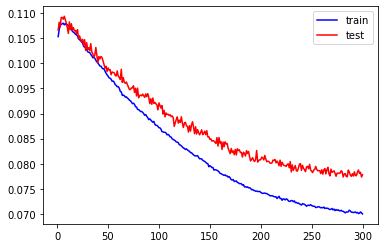

GD iterations:
i=0 | err=59.787682
i=1 | err=58.391357
i=2 | err=56.410812
i=3 | err=54.189434
i=4 | err=51.837364
i=5 | err=49.364742
i=6 | err=46.814075
i=7 | err=44.183033
i=8 | err=41.506260
i=9 | err=38.827072
i=10 | err=36.162399
i=11 | err=33.522095
i=12 | err=31.004303
i=13 | err=28.631927
i=14 | err=26.426752
i=15 | err=24.340006
i=16 | err=22.382435
i=17 | err=20.579321
i=18 | err=18.900333
i=19 | err=17.314621
i=20 | err=15.837305
i=21 | err=14.482753
i=22 | err=13.213870
i=23 | err=12.035194
i=24 | err=10.947244
i=25 | err=9.934706
i=26 | err=8.975080
i=27 | err=8.088917
i=28 | err=7.267724
i=29 | err=6.500605

FRAME 1 (INPUT) | FRAME 2 (INPUT) | FRAME 3 (INPUT) | FRAME 4 (GROUND-TRUTH) | FRAME 4 (PREDICTION)



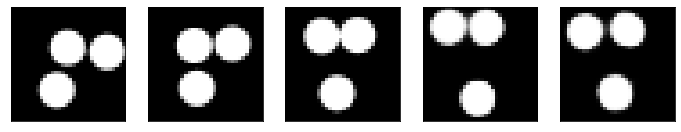

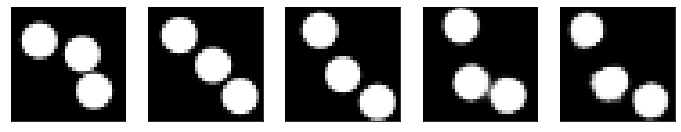

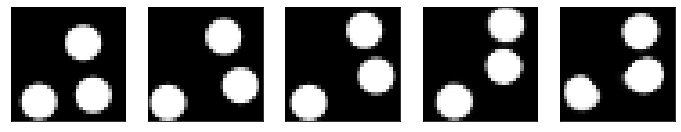

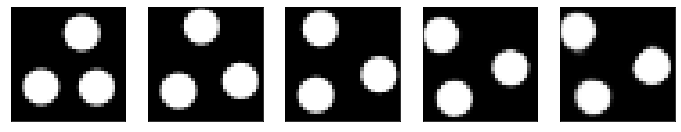

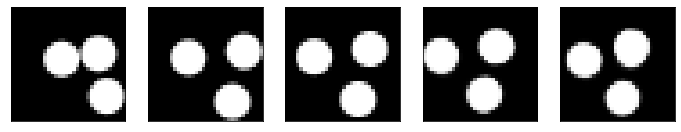

0.07781821638345718

In [163]:
print('Epoch = {}'.format(load_epoch))
print('Train MSE = {:.6f}'.format(train_errors[-1]))
print('Test MSE = {:.6f}'.format(test_errors[-1]))
plot_errors(train_errors, test_errors)
d.eval()
evaluate(d, verbose=True, num_show=5, threshold=threshold)

#### Plot an example 50-frame sequential prediction given 3 input frames. <br> Note no loss of fidelity due to use of discriminator.

In [173]:
d.eval()
examples = enumerate(codes_test_loader)
batch_idx, data = next(examples)
frames = []
verbose = False
    
I1 = dat[data[0:1,0,16].to(torch.long),0:1,:,:].to(torch.float).to(device)
I2 = dat[data[0:1,0,16].to(torch.long),1:2,:,:].to(torch.float).to(device)
I3 = dat[data[0:1,0,16].to(torch.long),2:3,:,:].to(torch.float).to(device)
I3_x = data[0:1,0,0:16]

frames = frames + [I1, I2, I3]

for i in range(50):
  f = (lambda x: -d(I1, I2, I3, ae.decode(x), activation=False).mean())
  x = input_gd(
    I3_x, f,
    steps=steps, lr=lr, momentum=momentum, verbose=verbose,
    zero_grad_f=optimizer.zero_grad, threshold=threshold
  )
  prediction = ae.decode(x).data
  frames.append(prediction)

  I1 = I2
  I2 = I3
  I3 = prediction
  I3_x = ae.encode(I3)

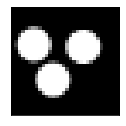

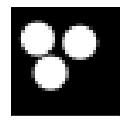

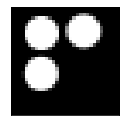

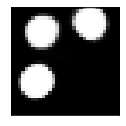

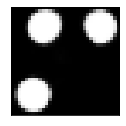

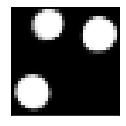

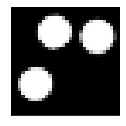

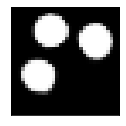

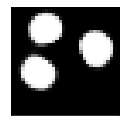

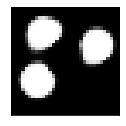

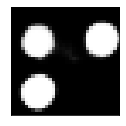

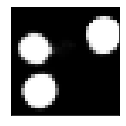

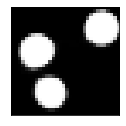

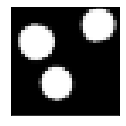

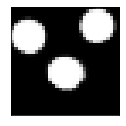

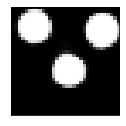

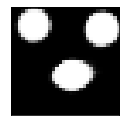

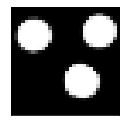

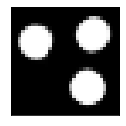

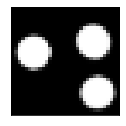

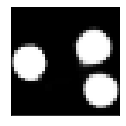

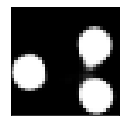

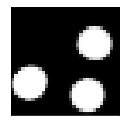

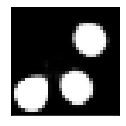

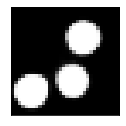

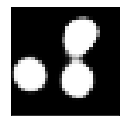

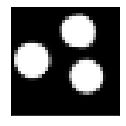

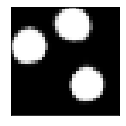

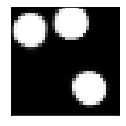

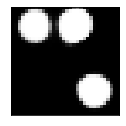

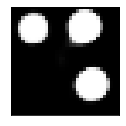

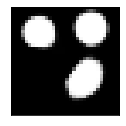

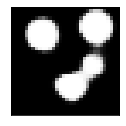

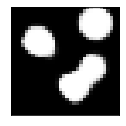

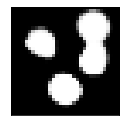

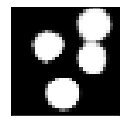

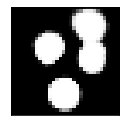

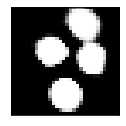

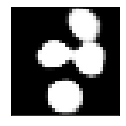

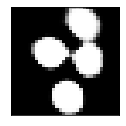

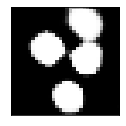

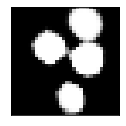

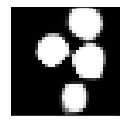

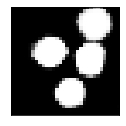

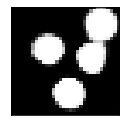

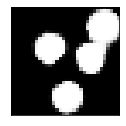

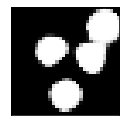

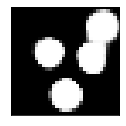

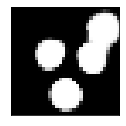

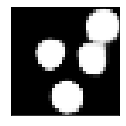

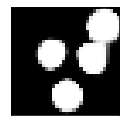

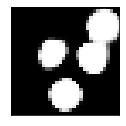

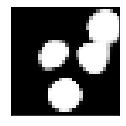

In [174]:
for i in range(len(frames)):
  frames[i] = frames[i].cpu().squeeze()
  
for im in frames:
  imshow_list([im], scale=0.5)